# X.1. Optimizing the S&P 500

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge
from sklearn.decomposition import PCA

In [3]:
import os
import sys
sys.path.insert(0, '../cmds')
from portfolio import *

In [4]:
LOADFILE = '../data/spx_returns_weekly.xlsx'
rets = pd.read_excel(LOADFILE, sheet_name='s&p500 rets').set_index('date')
FREQ = 52
rets = rets.iloc[:,::2]

In [5]:
GROSS_LIMIT = 4

In [6]:
Nt, Nk = rets.shape
ones = np.ones(Nt)

wts = pd.DataFrame(index = rets.columns,dtype=float) 
rp = pd.DataFrame(index = rets.index, dtype=float)

In [7]:
def penalized_reg_limit_gross(func, X, y, limit=2, penalty=1e-6, fit_intercept=True):
    wts = np.ones(X.shape[1]) * 100
    
    while np.abs(wts).sum()>limit:
        penalty *= 1.1
        model = func(alpha=penalty, fit_intercept=fit_intercept).fit(X,y)
        wts = model.coef_ / model.coef_.sum()
    
    return wts, penalty

### Equally Weighted

In [8]:
wts['equal'] = 1/Nk

### Risk Parity

In [9]:
wts['parity'] = 1/rets.std()

### MV

In [10]:
wts['mv'] = LinearRegression(fit_intercept=False).fit(rets,ones).coef_

In [11]:
wts['nonnegative'] = LinearRegression(fit_intercept=False,positive=True).fit(rets,ones).coef_

### Ridge

In [12]:
wts['ridge'], penalty_ridge = penalized_reg_limit_gross(Ridge,rets,ones,limit=GROSS_LIMIT,fit_intercept=False)

### LASSO

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    wts['lasso'], penalty_lasso = penalized_reg_limit_gross(Lasso,rets,ones,limit=GROSS_LIMIT,fit_intercept=False)

## Performance

In [14]:
wts /= wts.sum()
rp = rets @ wts
performanceMetrics(rp,annualization=FREQ)

,Mean,Vol,Sharpe,Min,Max
equal,0.1788,0.2008,0.8906,-0.1770,0.1791
parity,0.1712,0.1881,0.9102,-0.1672,0.1654
mv,1.5397,0.2417,6.3690,-0.0669,0.1226
nonnegative,0.3700,0.2010,1.8411,-0.1174,0.1139
ridge,0.6157,0.2339,2.6324,-0.1428,0.1366
lasso,0.9497,0.3453,2.7504,-0.2029,0.1743


In [15]:
tailMetrics(rp)

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
equal,-0.2653,11.1467,-0.0388,-0.0654,-0.3725,2020-02-14,2020-03-20,2020-10-09,238 days
parity,-0.3272,11.0979,-0.0358,-0.0614,-0.3476,2020-02-14,2020-03-20,2020-08-28,196 days
mv,-0.0438,-0.1561,-0.0250,-0.0402,-0.0983,2022-12-09,2022-12-30,2023-02-10,63 days
nonnegative,-0.1719,3.0516,-0.0387,-0.0579,-0.2560,2020-02-21,2020-03-20,2020-05-08,77 days
ridge,-0.2365,2.4189,-0.0407,-0.0640,-0.2541,2020-02-21,2020-03-20,2020-04-24,63 days
lasso,-0.1142,1.7263,-0.0583,-0.0891,-0.3141,2020-03-06,2020-03-20,2020-05-01,56 days


In [16]:
get_ols_metrics(rp['equal'],rp,annualization=FREQ)

,alpha,equal,r-squared,Treynor Ratio,Info Ratio
equal,-0.0000,1.0000,1.0000,0.1788,NaN
parity,0.0041,0.9340,0.9946,0.1833,0.3001
mv,1.5096,0.1683,0.0196,9.1468,6.3064
nonnegative,0.2256,0.8078,0.6514,0.4581,1.9010
ridge,0.4801,0.7580,0.4236,0.8122,2.7038
lasso,0.8086,0.7891,0.2106,1.2035,2.6357


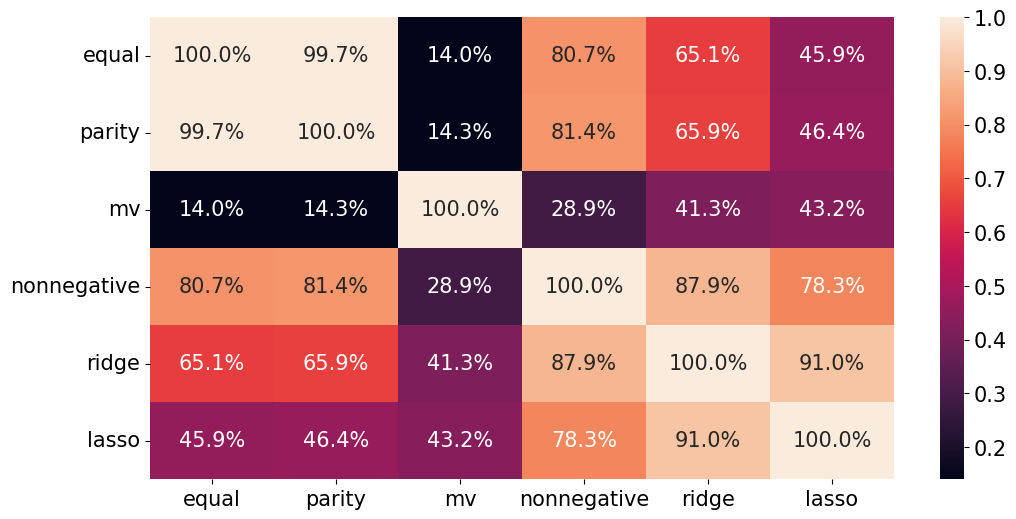

In [17]:
sns.heatmap(rp.corr(),annot=True,fmt='.1%');

## Understanding the Methods

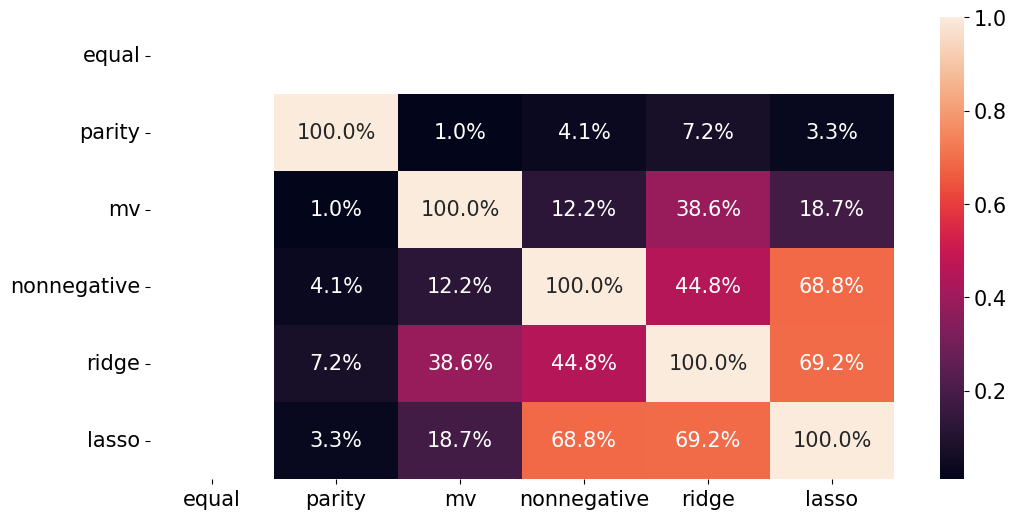

In [18]:
sns.heatmap(wts.corr(),annot=True,fmt='.1%');

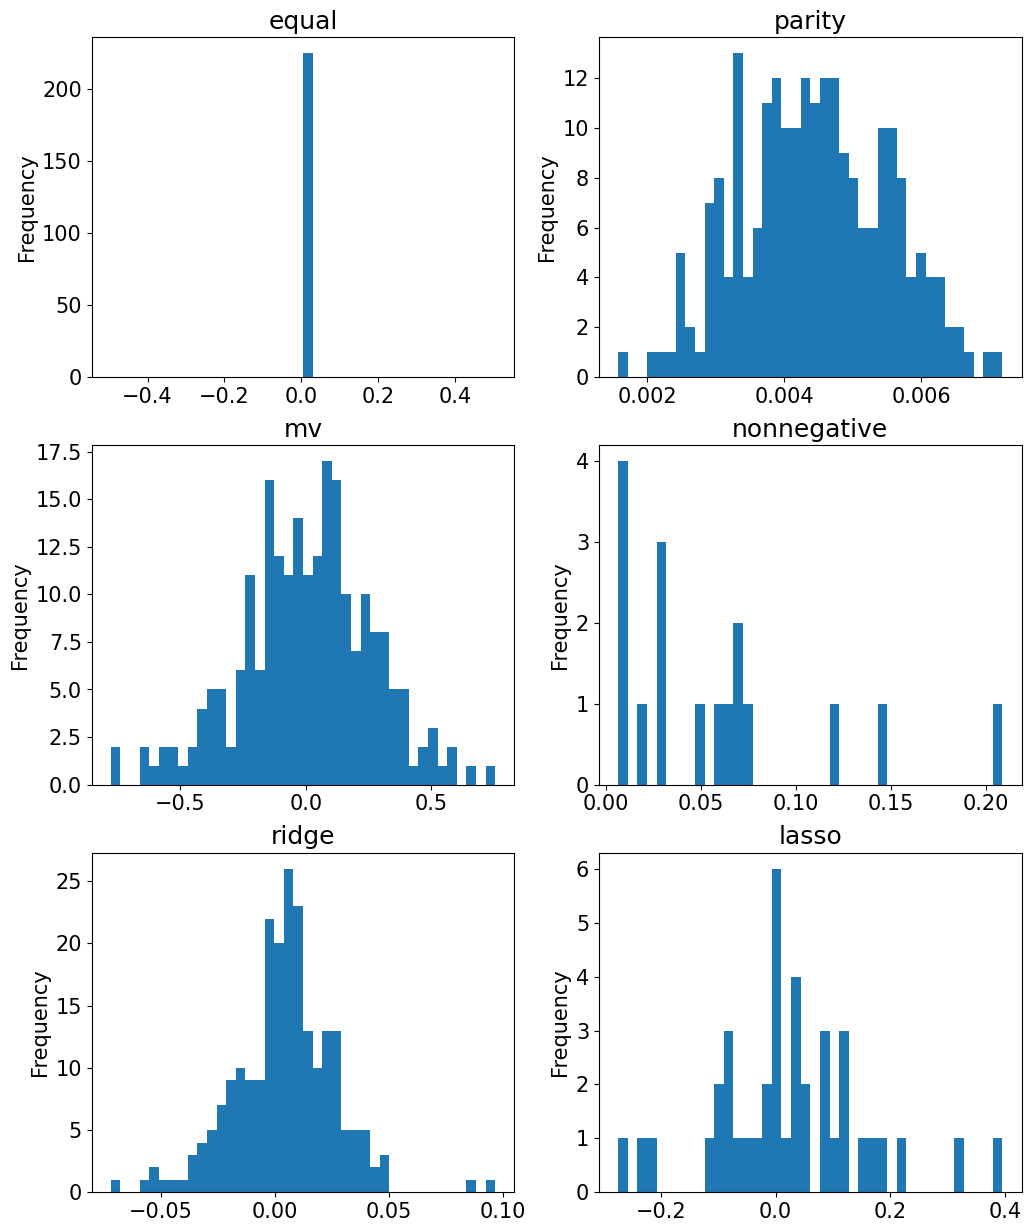

In [19]:
plotwts = wts.copy()
plotwts[plotwts.abs()<1e-4] = np.nan

fig, ax = plt.subplots(3,2,figsize=(12,15))
wmin = plotwts.min().min()
wmax = plotwts.max().max()
for i,method in enumerate(plotwts.columns):
    idplot = [int(np.floor(i/2)),i%2]
    plotwts[method].plot.hist(ax=ax[idplot[0],idplot[1]],bins=40,title=method)#,xlim=(wmin,wmax))

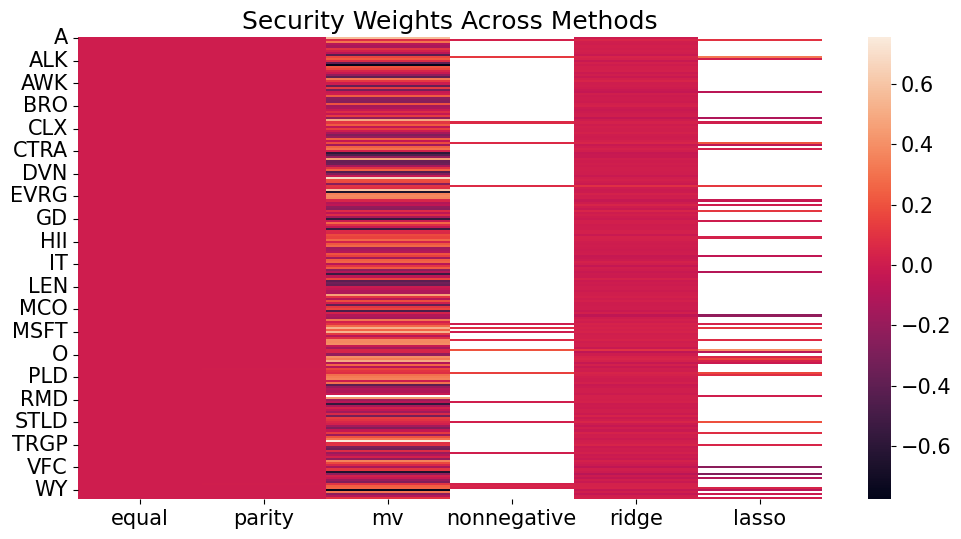

In [20]:
sns.heatmap(plotwts)
plt.title('Security Weights Across Methods')
plt.show()

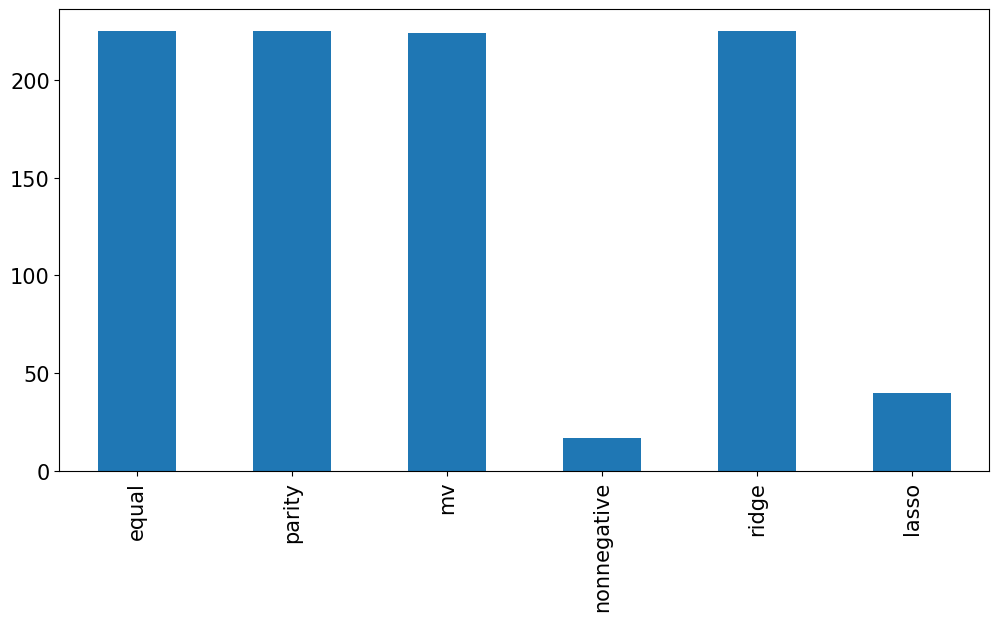

In [21]:
(wts.abs()>1e-4).sum().plot.bar();

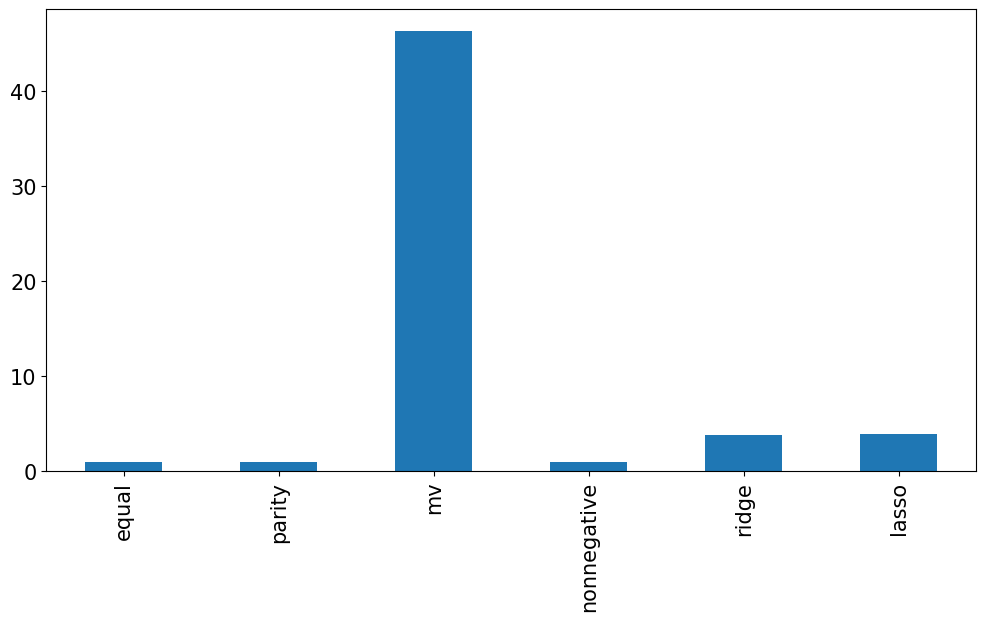

In [22]:
wts.abs().sum().plot.bar();

# Out of Sample

In [23]:
ADJUST_PENALTY = False
GROSS_LIMIT = 2

Nassets = Nk

minT = FREQ*4
methods = wts.columns

# initialize
wts_oos = pd.concat([pd.DataFrame(index=rets.index, columns=rets.columns)]*len(methods), keys=methods, axis=1)
equal_wts = np.ones(Nassets) / Nassets

In [24]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for t in wts_oos.index:    
        R = rets.loc[:t,:]
        y = np.ones(R.shape[0])

        if R.shape[0] >= minT:
            wts_oos.loc[t,'equal',] = equal_wts
            if 'SPY' in R.columns:
                wts_oos.loc[t,'SPY',] = 0
                wts_oos.loc[t,('SPY','SPY')] = 1

            wts_oos.loc[t,'mv',] = LinearRegression(fit_intercept=False).fit(R,y).coef_
            wts_oos.loc[t,'nonnegative',] = LinearRegression(positive=True, fit_intercept=False).fit(R,y).coef_    
            wts_oos.loc[t,'ridge',] = Ridge(alpha= penalty_ridge, fit_intercept=False).fit(R,y).coef_
            wts_oos.loc[t,'lasso',] = Lasso(alpha= penalty_lasso, fit_intercept=False).fit(R,y).coef_

            # dynamically adjust the penalty parameter
            # takes longer to run, brings gross leverage down
            if ADJUST_PENALTY:
                betas, penalty_ridge = penalized_reg_limit_gross(Ridge, R, y, limit=GROSS_LIMIT, fit_intercept=False)
                betas, penalty_lasso = penalized_reg_limit_gross(Lasso, R, y, limit=GROSS_LIMIT, fit_intercept=False)

for method in methods:
    div_factor = wts_oos[method].sum(axis=1)
    div_factor[div_factor==0] = 1
    wts_oos[method] = wts_oos[method].div(div_factor, axis='rows')

wts_oos_lag = wts_oos.shift(1)

CPU times: user 5min 7s, sys: 9min 6s, total: 14min 13s
Wall time: 1min 15s


In [25]:
rets_port_oos = pd.DataFrame(index=rets.index, columns = methods)

for method in methods:    
    rets_port_oos[method] = (wts_oos_lag[method] * rets).sum(axis=1)

# do not count burn-in period
rets_port_oos.iloc[:minT,:] = None

In [29]:
rets_port_oos.drop(columns='parity',inplace=True)
display(performanceMetrics(rets_port_oos, annualization=12).style.format('{:.2%}'.format))
display(tailMetrics(rets_port_oos))
display(get_ols_metrics(rp['equal'], rets_port_oos,annualization=FREQ).style.format('{:.2%}'.format))

,Mean,Vol,Sharpe,Min,Max
equal,3.76%,12.61%,29.85%,-17.70%,17.91%
mv,9.24%,672.29%,1.37%,-1443.75%,1963.79%
nonnegative,3.43%,12.12%,28.27%,-16.33%,10.38%
ridge,2.55%,14.72%,17.30%,-15.03%,14.82%
lasso,3.74%,27.02%,13.83%,-39.45%,22.12%


,Skewness,Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
equal,-0.1625,7.2078,-0.0525,-0.0830,-0.3725,2020-02-14,2020-03-20,2020-10-09,238 days
mv,3.3365,73.6753,-0.9592,-3.6333,"-2,460.8644",2020-01-24,2020-03-13,2020-04-10,77 days
nonnegative,-0.6599,3.5360,-0.0461,-0.0772,-0.3164,2020-02-21,2020-03-20,2020-07-10,140 days
ridge,-0.3642,1.5765,-0.0679,-0.0990,-0.2829,2021-11-19,2022-06-17,NaT,NaT
lasso,-0.8509,4.4470,-0.1040,-0.1862,-0.6537,2020-11-06,2023-01-06,NaT,NaT


,alpha,equal,r-squared,Treynor Ratio,Info Ratio
equal,-0.00%,100.00%,100.00%,17.88%,nan%
mv,183.83%,-881.45%,2.73%,-4.54%,13.32%
nonnegative,2.94%,73.00%,57.67%,20.34%,17.92%
ridge,4.28%,41.41%,12.59%,26.64%,14.93%
lasso,15.33%,5.29%,0.06%,306.01%,27.26%


In [30]:
wts_all = wts_oos.unstack().groupby(level=(0,2))
wts_all_diff = wts_oos.diff().unstack().groupby(level=(0,2))

gross_leverage = wts_all.apply(lambda x: sum(abs(x))).unstack(level=0)
turnover = wts_all_diff.apply(lambda x: sum(abs(x))).unstack(level=0)
num_positions = wts_all.apply(lambda x: sum(abs(x)>0)).unstack(level=0)
max_wt = wts_all.apply(lambda x: max(x)).unstack(level=0)
min_wt = wts_all.apply(lambda x: min(x)).unstack(level=0)

dates_active = (rets.index[minT],rets.index[-1])

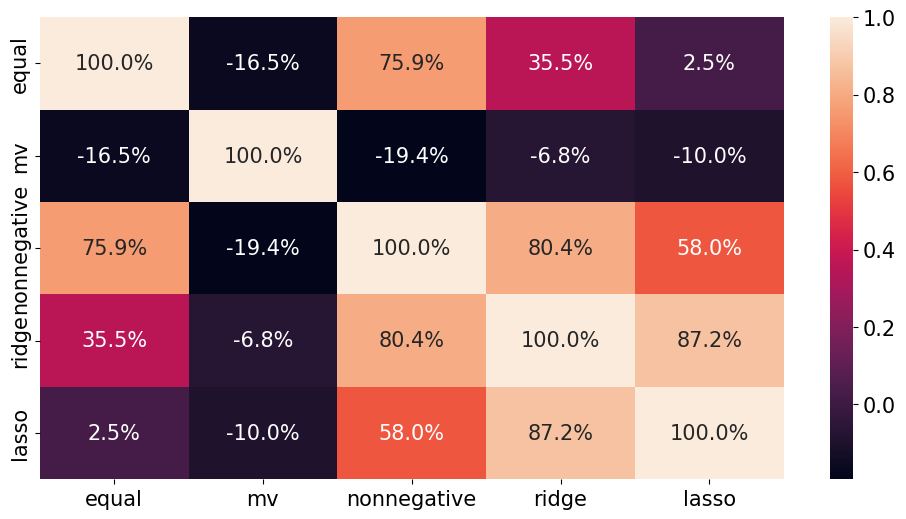

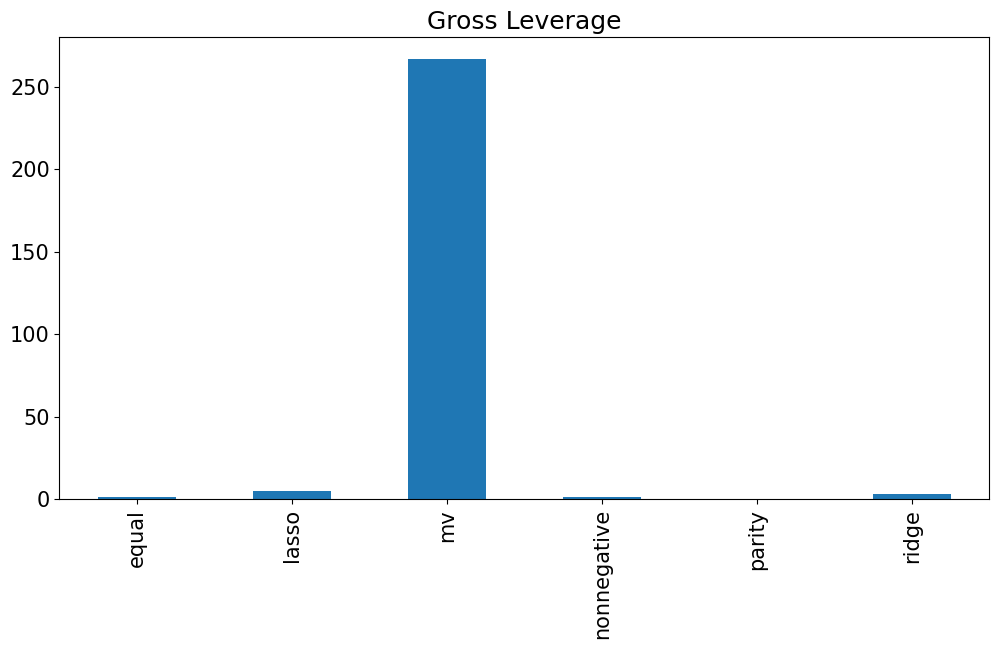

In [31]:
sns.heatmap(rets_port_oos.corr(),annot=True,fmt='.1%')
plt.show()
gross_leverage.mean().plot.bar(title='Gross Leverage');

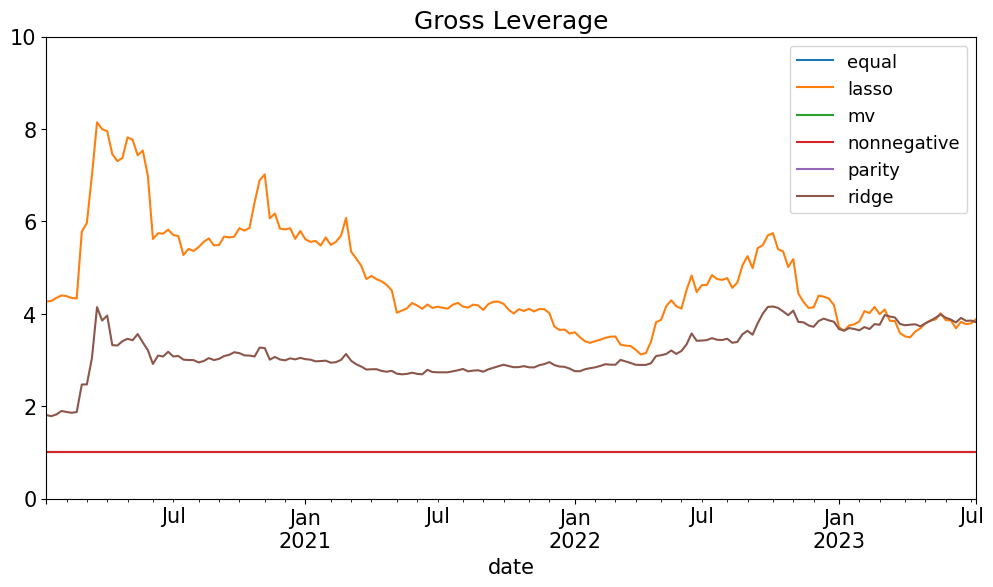

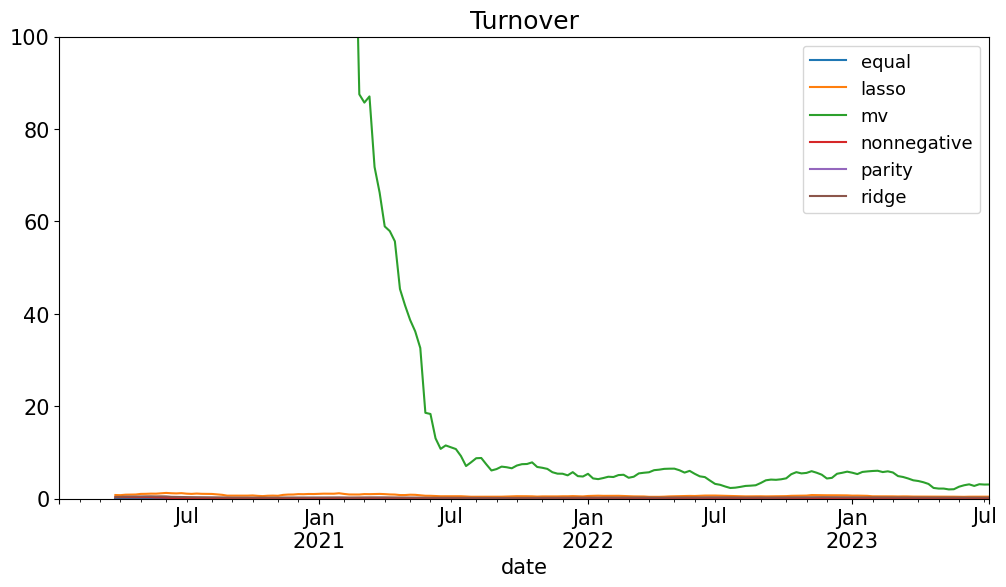

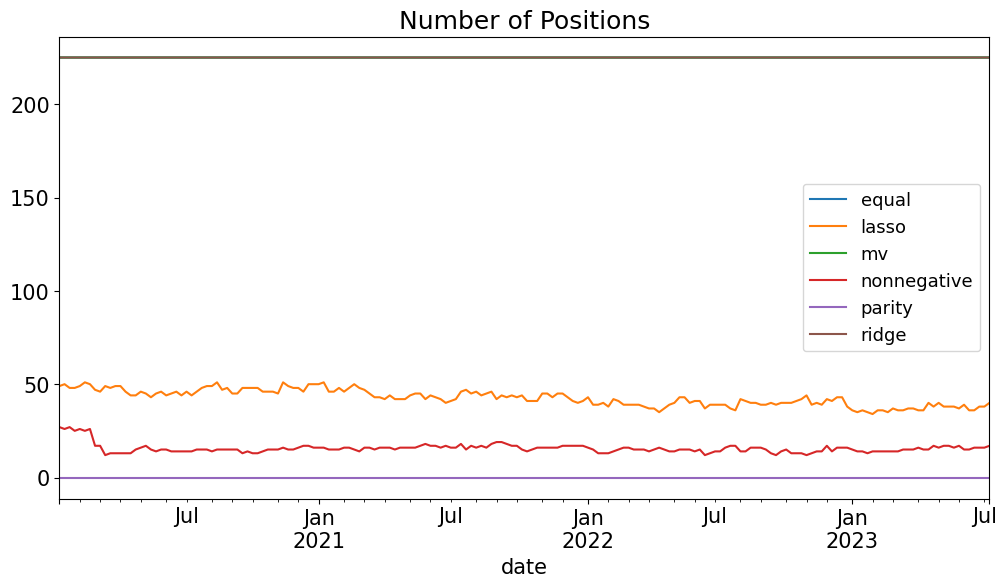

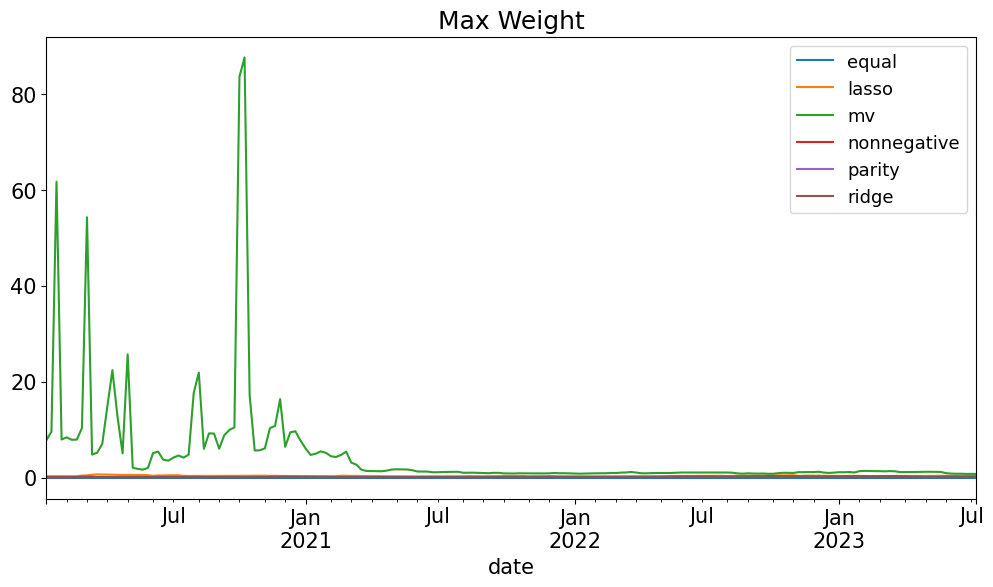

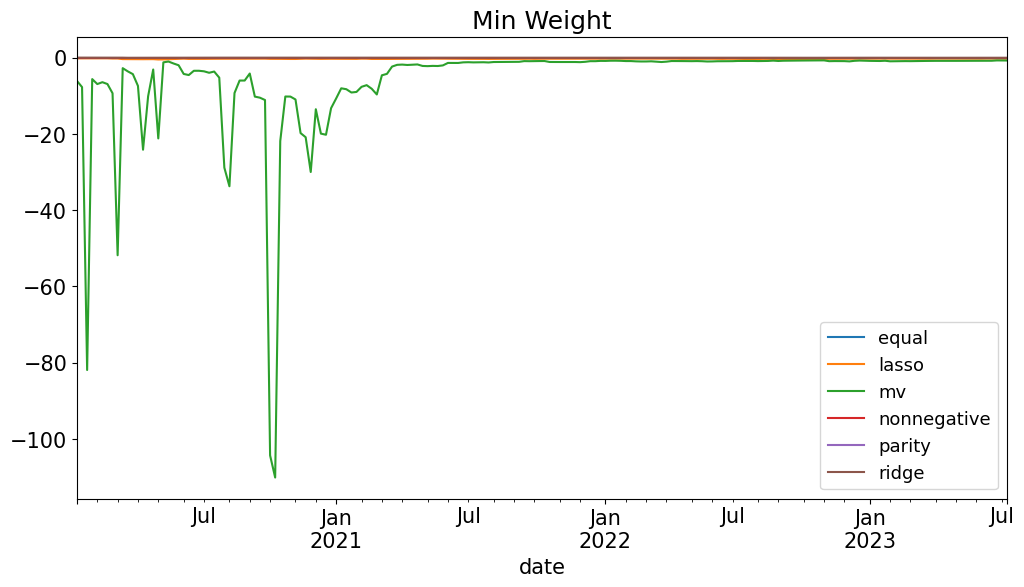

In [32]:
gross_leverage.plot(title='Gross Leverage',xlim=dates_active)
plt.ylim(0,10)
turnover.rolling(12*1).mean().plot(title='Turnover',xlim=dates_active)
plt.ylim(0,100)
plt.show()

num_positions.plot(title='Number of Positions',xlim=dates_active)
max_wt.plot(title='Max Weight',xlim=dates_active)
plt.show()
min_wt.plot(title='Min Weight',xlim=dates_active)
plt.show()